In [1]:
# Preparing dataset in jupyternotbook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import PorterStemmer
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
# Import the train test split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
# To evaluate our model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import joblib as joblib
%matplotlib inline
# Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nkantanong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nkantanong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nkantanong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read file

In [3]:
# Read the csv file into a pandas DataFrame
df = pd.read_csv('training_list3withtype.csv')
df.head()
# Input of the training will be on column'filename' and using column 'doctype' for classification/categorise

,doctype,subtype,path,filename,ext
0,operations and drilling,operations and drilling,\Swallow-1\D00014084\Swallow-1 Re-entry Operat...,Swallow-1 Re-entry Operations Summary Rev 0.pdf,pdf
1,well report,form,\Swallow-1\P00575562\Coogee QC Form.doc,Coogee QC Form.doc,doc
2,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,Swallow-1_ LWD_DDS_REC_R100_145-1210.las,las
3,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,Swallow-1_ LWD_DDS_REC_R200_160306-170306.las,las
4,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,Swallow-1_ LWD_DDS_REC_R300_180306-200306.las,las


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357 entries, 0 to 1356
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   doctype   1357 non-null   object
 1   subtype   1357 non-null   object
 2   path      1357 non-null   object
 3   filename  1357 non-null   object
 4   ext       1357 non-null   object
dtypes: object(5)
memory usage: 53.1+ KB


In [5]:
# Check column names
df.columns

Index(['doctype', 'subtype', 'path', 'filename', 'ext'], dtype='object')

In [6]:
# Drop (duplicates) and incomplete rows
print(df.count())
df = df.dropna()
df = df.drop_duplicates()
print(df.count())

doctype     1357
subtype     1357
path        1357
filename    1357
ext         1357
dtype: int64
doctype     1357
subtype     1357
path        1357
filename    1357
ext         1357
dtype: int64


In [7]:
# Check variation/number of document types we have in the list before training
print(df['doctype'].value_counts())
print(df['doctype'].value_counts(normalize=True))

well log                    866
well report                 208
palynology and core data    169
operations and drilling     114
Name: doctype, dtype: int64
well log                    0.638172
well report                 0.153279
palynology and core data    0.124539
operations and drilling     0.084009
Name: doctype, dtype: float64


Text(0, 0.5, 'Document category')

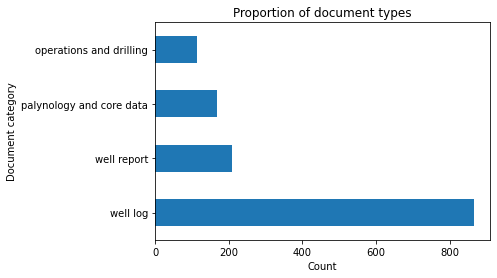

In [8]:
# Check porportions of each doctype
# we have unbalance category, 'Well log' type contains the larget portion for this training
count = df['doctype'].value_counts()
count.plot(kind='barh')
plt.title("Proportion of document types")
plt.xlabel("Count")
plt.ylabel("Document category")

In [9]:
# Initialize Label Encoder
le = LabelEncoder()
df['doctype_enc'] = le.fit_transform(df['doctype'])
df.head()
#Catagory: operations and drilling(0),palynology and core data(1),well log (2),well report(3)

,doctype,subtype,path,filename,ext,doctype_enc
0,operations and drilling,operations and drilling,\Swallow-1\D00014084\Swallow-1 Re-entry Operat...,Swallow-1 Re-entry Operations Summary Rev 0.pdf,pdf,0
1,well report,form,\Swallow-1\P00575562\Coogee QC Form.doc,Coogee QC Form.doc,doc,3
2,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,Swallow-1_ LWD_DDS_REC_R100_145-1210.las,las,2
3,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,Swallow-1_ LWD_DDS_REC_R200_160306-170306.las,las,2
4,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,Swallow-1_ LWD_DDS_REC_R300_180306-200306.las,las,2


In [10]:
df.dtypes

doctype        object
subtype        object
path           object
filename       object
ext            object
doctype_enc     int32
dtype: object

## Data cleaning and pre-preparation

In [11]:
# Input of the training will be on column'filename' and using classification/category from column 'doctype_enc'
# Remove special characters using regex
sp_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in sp_chars:
    df['filename'] = df['filename'].str.replace(char, ' ')

In [12]:
# Remove number from 'filename' using regex and convert to lower case
df['filename'] = df['filename'].str.replace('\d+', ' ').str.lower()
df

,doctype,subtype,path,filename,ext,doctype_enc
0,operations and drilling,operations and drilling,\Swallow-1\D00014084\Swallow-1 Re-entry Operat...,swallow re entry operations summary rev pdf,pdf,0
1,well report,form,\Swallow-1\P00575562\Coogee QC Form.doc,coogee qc form doc,doc,3
2,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,swallow lwd dds rec r las,las,2
3,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,swallow lwd dds rec r las,las,2
4,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,swallow lwd dds rec r las,las,2
...,...,...,...,...,...,...
1352,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,hyde appendix distchart xls,xls,1
1353,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,hyde a interp paly aug pdf,pdf,1
1354,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,table hyde a xlsx,xlsx,1
1355,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,hyde petrophysics report pdf,pdf,1


In [13]:
# Remove file format as shown in column 'ext' (pdf, las, doc)
file_format = df.ext.unique()
for ext in file_format:
    df['filename'] = df['filename'].str.replace(ext, '')
df

,doctype,subtype,path,filename,ext,doctype_enc
0,operations and drilling,operations and drilling,\Swallow-1\D00014084\Swallow-1 Re-entry Operat...,swallow re entry operations summary rev,pdf,0
1,well report,form,\Swallow-1\P00575562\Coogee QC Form.doc,coogee qc form,doc,3
2,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,swallow lwd dds rec r,las,2
3,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,swallow lwd dds rec r,las,2
4,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,swallow lwd dds rec r,las,2
...,...,...,...,...,...,...
1352,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,hyde appendix distchart,xls,1
1353,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,hyde a interp paly aug,pdf,1
1354,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,table hyde a x,xlsx,1
1355,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,hyde petrophysics ort,pdf,1


In [14]:
# Remove proper noun (such as well name that usually find in 'file name')
well_list = ['appendix','chevron','slb','swallow', 'corvus', 'clio','franklin','fish','river','banka','garganey','yyche','backpacker','coogee','charon','cisticola','geelvink','koel','lilac','livet','munia','moogooree','curvus','hyde']
for well in well_list:
    df['filename'] = df['filename'].str.replace(well, ' ')
df

,doctype,subtype,path,filename,ext,doctype_enc
0,operations and drilling,operations and drilling,\Swallow-1\D00014084\Swallow-1 Re-entry Operat...,re entry operations summary rev,pdf,0
1,well report,form,\Swallow-1\P00575562\Coogee QC Form.doc,qc form,doc,3
2,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,lwd dds rec r,las,2
3,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,lwd dds rec r,las,2
4,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,lwd dds rec r,las,2
...,...,...,...,...,...,...
1352,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,distchart,xls,1
1353,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,a interp paly aug,pdf,1
1354,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,table a x,xlsx,1
1355,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,petrophysics ort,pdf,1


In [15]:
# remove words less than 3 characters
# df['filename'].str.findall('\w{3,}').str.join(' ')
df['filename'] = df['filename'].str.split().map(lambda sl: " ".join(s for s in sl if len(s) > 2))
df

,doctype,subtype,path,filename,ext,doctype_enc
0,operations and drilling,operations and drilling,\Swallow-1\D00014084\Swallow-1 Re-entry Operat...,entry operations summary rev,pdf,0
1,well report,form,\Swallow-1\P00575562\Coogee QC Form.doc,form,doc,3
2,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,lwd dds rec,las,2
3,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,lwd dds rec,las,2
4,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,lwd dds rec,las,2
...,...,...,...,...,...,...
1352,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,distchart,xls,1
1353,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,interp paly aug,pdf,1
1354,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,table,xlsx,1
1355,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,petrophysics ort,pdf,1


In [16]:
# # Remove whitespace(s) between words and then rejoin
# df['filename'] = df['filename'].str.split().str.join(" ")
# df

In [17]:
# Re-check and Drop (duplicates) and incomplete rows
print(df.count())
df = df.dropna()
df = df.drop_duplicates()
print(df.count())

doctype        1357
subtype        1357
path           1357
filename       1357
ext            1357
doctype_enc    1357
dtype: int64
doctype        1357
subtype        1357
path           1357
filename       1357
ext            1357
doctype_enc    1357
dtype: int64


## Export clean data

In [18]:
# # # Export clean list as .csv
df.to_csv(r'C:\Users\nkantanong\BootCamp\Final_Project\Final_Project_NS\nlp\list_clean1.csv', index = False)

## Preparation data for training

In [19]:
# Check column names
df.columns

Index(['doctype', 'subtype', 'path', 'filename', 'ext', 'doctype_enc'], dtype='object')

In [20]:
# Tokenized
tokenized1 = df['filename'].str.lower().apply(word_tokenize)
tokenized1

0       [entry, operations, summary, rev]
1                                  [form]
2                         [lwd, dds, rec]
3                         [lwd, dds, rec]
4                         [lwd, dds, rec]
                      ...                
1352                          [distchart]
1353                  [interp, paly, aug]
1354                              [table]
1355                  [petrophysics, ort]
1356                           [analysis]
Name: filename, Length: 1357, dtype: object

In [21]:
# Remove stop words with additional names (well lists that show in the file name)
# well_list = ['swallow', 'clio','franklin','fish','river','banka','garganey','yyche','backpacker','coogee','charon','cisticola','geelvink','koel','lilac','livet','munia','moogooree','curvus','hyde']
# def remover(tokens):
#     stopwords = set(stopwords.words('english'))
#     new_words =('swallow', 'clio','franklin','fish','river','banka','garganey','yyche','backpacker','charon','cisticola','geelvink','koel','lilac','livet','munia','moogooree','curvus','hyde')
#     for i in new_words:
#         stopwords.append(i)

# final_stop_words = all_stop_words.extend(well_list)
# remover = StopWordsRemover(inputCol="words", outputCol="filtered")
# tokenized_name = tokenized_name.apply(stopwords)
# tokenized_name

In [22]:
# Define function to remove stop words
def remove_stop_words(tokens):
    no_stop = []
#     stopwords = nltk.corpus.stopwords.words('english')
    for token in tokens:
        if token not in stopwords.words('english'):
            no_stop.append(token)
    return no_stop

# Apply our function to tokens
tokenized = tokenized1.apply(remove_stop_words)
tokenized

0       [entry, operations, summary, rev]
1                                  [form]
2                         [lwd, dds, rec]
3                         [lwd, dds, rec]
4                         [lwd, dds, rec]
                      ...                
1352                          [distchart]
1353                  [interp, paly, aug]
1354                              [table]
1355                  [petrophysics, ort]
1356                           [analysis]
Name: filename, Length: 1357, dtype: object

In [23]:
# Define function to lemmatization
def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    # Create the lemmatized list
    lemmatized = []
    for token in tokens:
            # Lemmatize and append
            lemmatized.append(lemmatizer.lemmatize(token))
    return " ".join(lemmatized)

# Apply our function to tokens
tokenized = tokenized1.apply(lemmatize)
tokenized

0       entry operation summary rev
1                              form
2                        lwd dd rec
3                        lwd dd rec
4                        lwd dd rec
                   ...             
1352                      distchart
1353                interp paly aug
1354                          table
1355               petrophysics ort
1356                       analysis
Name: filename, Length: 1357, dtype: object

In [24]:
# assign tokenized to dataframe
df2 = df.assign(tokenized = tokenized)
df2.head(5)

,doctype,subtype,path,filename,ext,doctype_enc,tokenized
0,operations and drilling,operations and drilling,\Swallow-1\D00014084\Swallow-1 Re-entry Operat...,entry operations summary rev,pdf,0,entry operation summary rev
1,well report,form,\Swallow-1\P00575562\Coogee QC Form.doc,form,doc,3,form
2,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,lwd dds rec,las,2,lwd dd rec
3,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,lwd dds rec,las,2,lwd dd rec
4,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,lwd dds rec,las,2,lwd dd rec


In [25]:
# assign words count (tokenized count) to dataframe
df2['tokenized_count'] = [len(x.split()) for x in df2['tokenized'].tolist()]
df2

,doctype,subtype,path,filename,ext,doctype_enc,tokenized,tokenized_count
0,operations and drilling,operations and drilling,\Swallow-1\D00014084\Swallow-1 Re-entry Operat...,entry operations summary rev,pdf,0,entry operation summary rev,4
1,well report,form,\Swallow-1\P00575562\Coogee QC Form.doc,form,doc,3,form,1
2,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,lwd dds rec,las,2,lwd dd rec,3
3,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,lwd dds rec,las,2,lwd dd rec,3
4,well log,log,\Swallow-1\P00575562\LAS\Swallow-1_ LWD_DDS_RE...,lwd dds rec,las,2,lwd dd rec,3
...,...,...,...,...,...,...,...,...
1352,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,distchart,xls,1,distchart,1
1353,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,interp paly aug,pdf,1,interp paly aug,3
1354,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,table,xlsx,1,table,1
1355,palynology and core data,palynology,\Hyde\P00711410\Hyde-1_1A_WCR\Hyde-1A_Interpre...,petrophysics ort,pdf,1,petrophysics ort,2


In [26]:
# # # Export cleaned list#2 as .csv
df2.to_csv(r'C:\Users\nkantanong\BootCamp\Final_Project\Final_Project_NS\nlp\list_clean2.csv', index = False)

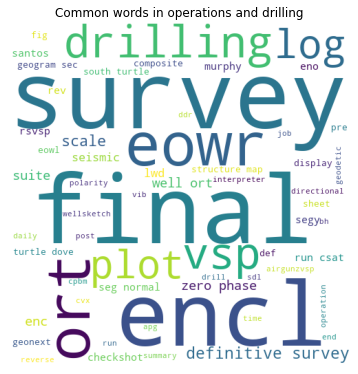

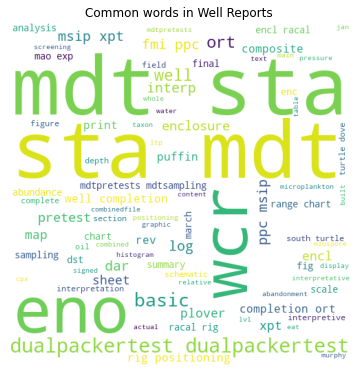

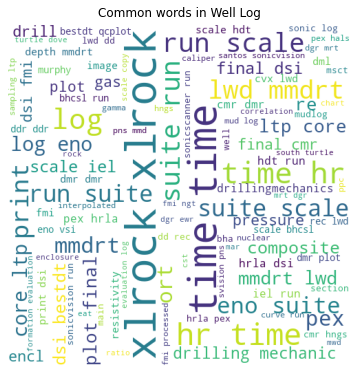

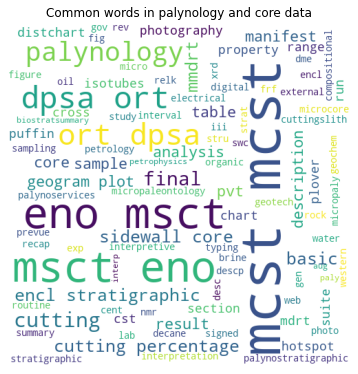

In [27]:
# Get all document catagories
od = df2[df2['doctype']=='operations and drilling']['tokenized'].str.cat(sep=' ')
wr = df2[df2['doctype']=='well report']['tokenized'].str.cat(sep=' ')
wl = df2[df2['doctype']=='well log']['tokenized'].str.cat(sep=' ')
paly = df2[df2['doctype']=='palynology and core data']['tokenized'].str.cat(sep=' ')

# Initialize the word cloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color ='white')

# Generate the world clouds for each type of message
od_wc = wc.generate(od)

# plot the world cloud for operations and drilling documents                     
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(od_wc) 
plt.axis("off") 
plt.title("Common words in operations and drilling")
plt.tight_layout(pad = 0) 
plt.show() 

wr_wc = wc.generate(wr)

# plot the world cloud for Well Report                   
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wr_wc) 
plt.axis("off") 
plt.title("Common words in Well Reports")
plt.tight_layout(pad = 0) 
plt.show() 

# ##########
wl_wc = wc.generate(wl)

# plot the world cloud for Well log                   
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wl_wc) 
plt.axis("off") 
plt.title("Common words in Well Log")
plt.tight_layout(pad = 0) 
plt.show() 

# Generate the world clouds for Palynology
paly_wc = wc.generate(paly)

# plot the world cloud for operations and drilling documents                     
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(paly_wc) 
plt.axis("off") 
plt.title("Common words in palynology and core data")
plt.tight_layout(pad = 0) 
plt.show() 

## Build model

In [28]:
# use stratify parameter of train_test_split since our data is not balanced
X = df2['tokenized']
y = df2['doctype_enc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)

In [29]:
# Create the tf-idf vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii')

# create training and testing set using the same vectorizer
tfidf_train = vectorizer.fit_transform(X_train)
tfidf_test = vectorizer.transform(X_test)

In [33]:
# Initialize the Multinomial Naive Bayes classifier
nb = MultinomialNB()

# Fit the model
nb.fit(tfidf_train, y_train)

# Print the accuracy score
print("Accuracy score:",nb.score(tfidf_test, y_test))

Accuracy score: 0.8786764705882353


In [35]:
# Save the model as a pickle in a file
joblib.dump(nb, 'nb_model.pkl')
 
# # Load the model from the file
# nb_from_joblib = joblib.load('nb_model.pkl')
 
# # Use the loaded model to make predictions
# nb_from_joblib.predict(X_test)

['nb_model.pkl']

In [36]:
# Predict the doc type
y_pred = nb.predict(tfidf_test)


# Print the Confusion Matrix
cmatrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cmatrix)



# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)



# # Get probabilities.
# y_pred_proba = nb.predict(tfidf_test)

# # # # Print the Receiver operating characteristic Auc score
# auc_score = roc_auc_score(y, y_pred_proba, multi_class='ovr')

# print("\nROC AUC Score:",auc_score)



# # # # Get False Positive rate, True Positive rate and the threshold
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)



Confusion Matrix

[[  5   0  18   0]
 [  0  30   3   1]
 [  0   1 171   1]
 [  0   0   9  33]]


Classification Report

              precision    recall  f1-score   support

           0       1.00      0.22      0.36        23
           1       0.97      0.88      0.92        34
           2       0.85      0.99      0.91       173
           3       0.94      0.79      0.86        42

    accuracy                           0.88       272
   macro avg       0.94      0.72      0.76       272
weighted avg       0.89      0.88      0.86       272

